In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
os.chdir("E:\大学\实习\简历\项目\淘宝用户分析")

In [3]:
data_user = pd.read_csv(r"tianchi_mobile_recommend_train_user.csv")

In [ ]:
'''
user_id：用户身份，脱敏

item_id：商品ID，脱敏

behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）

user_geohash：地理位置

item_category：品类ID（商品所属的品类）

time：用户行为发生的时间
'''

In [ ]:
'''
用户分析的指标，一共四个大类：
用户购买行为研究（访问率分析、消费次数和金额分析、流失和复购分析）
用户价值分析（RFM）
用户生命周期分析（本项目只提供了一个月的数据，无法得出准确的用户生命周期分析，因此这一部分暂不讨论）
用户数据分析即用户画像（本项目因缺乏相关数据，因此这一部分暂不讨论）
'''

# 1. 数据清洗

### 1.1 缺失值处理

In [4]:
#将各列缺失值进行计数，按照降序排列
missingTotal = data_user.isnull().sum()
missingExist = missingTotal[missingTotal>0]
missingExist = missingExist.sort_values(ascending=False)
print(missingExist)

user_geohash    8334824
dtype: int64


In [5]:
#仅地理位置信息存在缺失，其他数据是完整的。
#且因为地理位置是转码过的，因此先不对缺失值进行处理。

### 1.2 一致化处理

In [6]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [7]:
#将时间列进行进一步处理，转化为日期列和小时列

In [8]:
data_user['date']=data_user['time'].map(lambda x: x.split(' ')[0])
data_user['hour']=data_user['time'].map(lambda x: x.split(' ')[1])
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [9]:
#将数据转换成相应的类型，time和date应该是日期类型数据，hour应该是字符串类型数据

In [10]:
data_user['time'] = pd.to_datetime(data_user['time'], format='%Y-%m-%d %H')
data_user['date'] = pd.to_datetime(data_user['date'], format='%Y-%m-%d')
data_user['hour'] = data_user['hour'].astype('int64')

In [11]:
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

### 1.3 异常值处理

In [12]:
data_user.describe(include='all')

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
count,1.225691e+07,1.225691e+07,1.225691e+07,3922082,1.225691e+07,12256906,12256906,1.225691e+07
unique,NaN,NaN,NaN,575458,NaN,744,31,NaN
top,NaN,NaN,NaN,94ek6ke,NaN,2014-12-11 22:00:00,2014-12-12 00:00:00,NaN
freq,NaN,NaN,NaN,1052,NaN,54797,691712,NaN
first,NaN,NaN,NaN,NaN,NaN,2014-11-18 00:00:00,2014-11-18 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2014-12-18 23:00:00,2014-12-18 00:00:00,NaN
mean,7.170732e+07,2.023084e+08,1.105271e+00,NaN,6.846162e+03,NaN,NaN,1.481799e+01
std,4.122920e+07,1.167397e+08,4.572662e-01,NaN,3.809922e+03,NaN,NaN,6.474778e+00
min,4.913000e+03,6.400000e+01,1.000000e+00,NaN,2.000000e+00,NaN,NaN,0.000000e+00
25%,3.584965e+07,1.014130e+08,1.000000e+00,NaN,3.721000e+03,NaN,NaN,1.000000e+01


In [13]:
#主要为离散型+有序型数据，未发现异常值的出现

# 2.用户分析

### 2.1 用户购买行为分析

#### 2.1.1用户购买行为综述

In [14]:
min_date, max_date = min(data_user['date']), max(data_user['date'])

In [15]:
min_date, max_date

(Timestamp('2014-11-18 00:00:00'), Timestamp('2014-12-18 00:00:00'))

In [16]:
user_num = data_user['user_id'].unique()
item_num = data_user['item_id'].unique()
item_category_num = data_user['item_category'].unique()
len(user_num), len(data_user['behavior_type']), len(item_num), len(item_category_num)

(10000, 12256906, 2876947, 8916)

In [ ]:
"""
2014年11月18日至2014年12月18日的用户行为数据
#10000名用户，总共发生约1226万次
#涉及商品数量为287万件物品，分为8916类

"""

#### 2.1.2 用户访问率分析

In [17]:
# 1) 日访问量分析

In [ ]:
"""
PV(访问量)：即Page View,具体是指网站的页面浏览量或者点击量。

UC(独立访客)：即Unique Visitor,指访问网站的一台电脑客户端为一个访客。

"""

In [18]:
pv_daily = data_user.groupby('date')["user_id"].count().reset_index().rename(columns={'user_id':'pv'})
uv_daily = data_user.groupby('date')["user_id"].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})
#groupby函数处理后 index会变成date，因此需要reset_index
#pv_daily记录每天用户操作次数，uv_daily记录每天不同的上线用户数量

Text(0.5,1,'uv_daily')

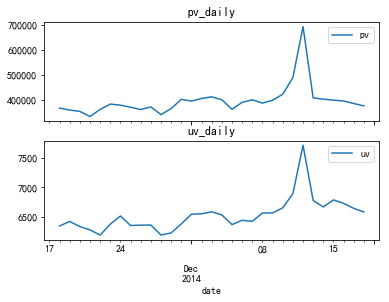

In [19]:
fig,axes=plt.subplots(2,1,sharex=True)
pv_daily.plot(x='date',y='pv',ax=axes[0])
uv_daily.plot(x='date',y='uv',ax=axes[1])
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')
#可视化pv_daily和uv_daily

In [ ]:
"""


给定数据集总人数大约10000人，
pv访问量集中在40万次，uv访问量集中在6500
并且可以发现，uv和pv两个访问量数值差距比较大，


在双十二期间，pv和uv访问量达到峰值（分别为70万和7500左右），
通过uv值可以分析出双十二期间淘宝用户的
日活跃增长幅度为(7500-6500)/6500 = 15%

"""

In [20]:
# 2) 小时访问量分析

In [ ]:
"""
pv_hour记录每小时用户操作次数

uv_hour记录每小时不同的上线用户数量
"""

In [21]:
pv_hour = data_user.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
uv_hour = data_user.groupby('hour')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})

Text(0.5,1,'uv_hour')

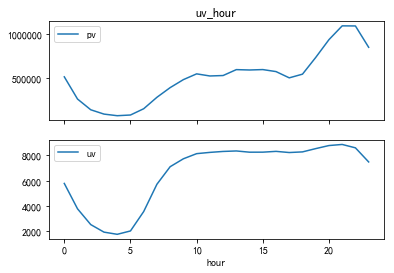

In [22]:
fig,axes=plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv',ax=axes[0])
uv_hour.plot(x='hour',y='uv',ax=axes[1])
axes[0].set_title('pv_hour')
axes[0].set_title('uv_hour')

In [ ]:
"""
pv和uv在凌晨（0点至5点）呈现下降趋势，并于清晨（5点至10点）开始上升，
正午达到平稳并持续到18点左右，访问量于夜晚继续提升并且在21点左右达到峰值。

18点左右的pv波动比较剧烈，相比之下uv并无十分剧烈的波动
因此18点左右，晚间时段是淘宝app的活跃时间段
"""

In [23]:
# 3) 不同行为类型用户pv分析

In [ ]:
"""
pv_detail记录不同类型用户的pv访问量情况

"""

In [24]:
pv_detail = data_user.groupby(['behavior_type',"hour"])["user_id"].count().reset_index().rename(columns={'user_id':'total_pv'})

Text(0.5,1,'pv_different_behavior_type_except1')

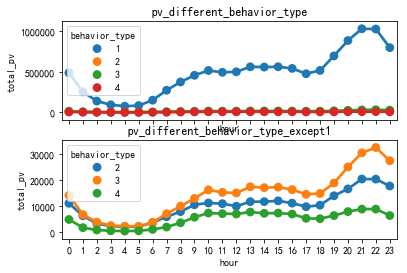

In [25]:
fig,axes=plt.subplots(2,1,sharex=True)
sns.pointplot(x='hour',y='total_pv',hue='behavior_type',data=pv_detail,ax=axes[0])
sns.pointplot(x='hour',y='total_pv',hue='behavior_type',data=pv_detail[pv_detail.behavior_type!=1],ax=axes[1])
axes[0].set_title('pv_different_behavior_type')
axes[1].set_title('pv_different_behavior_type_except1')

In [26]:
#pointplot()函数
#点图表示通过散点图点的位置对数值变量的中心趋势的估计。
#点图用于集中在一个或多个分类变量的不同级别之间的比较，有时比条形图更有用。
#x,y常用来指定x,y轴的分类名称，
#hue常用来指定第二次分类的数据类别(用颜色区分)

In [ ]:
"""
点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示

点击这一用户行为较其他三类行为pv访问量较高，符合预期

四种行为的波动情况基本一致，最高峰都集中在夜晚

加入购物车的pv访问量 高于收藏的pv访问量
"""

#### 2.1.3 用户消费行为分析 

In [27]:
# 1) 用户购买次数情况分析

In [ ]:
"""
data_user_buy表示每个用户的购买的次数
"""

In [28]:
data_user_buy = data_user[data_user['behavior_type']==4].groupby('user_id')['behavior_type'].count().reset_index().rename(columns={'behavior_type':'total_buy'})

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'daily_user_buy')

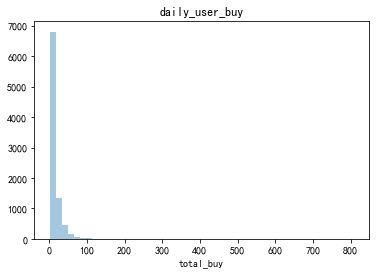

In [29]:
sns.distplot(data_user_buy.total_buy,kde=False)
plt.title('daily_user_buy')

In [ ]:
"""
seaborn.distplot() 直方图，质量估计图，核密度估计图

hist=True:表示要绘制直方图(默认情况为True)，若为False，则不绘制

kde=True:表示要绘制核密度估计图(默认情况为True),若为False,则绘制
"""

In [30]:
#因存在购买次数过高的用户，无法从可视化中获取有效信息，需要进行异常值处理
#采用箱型图：IQR(差值) = U(上四分位数) - L(下四分位数)来识别异常值

In [31]:
iqr = data_user_buy.total_buy.quantile(0.75) - data_user_buy.total_buy.quantile(0.25)
q_abnormal_U = data_user_buy.total_buy.quantile(0.75) + 1.5 * iqr

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'daily_user_buy_normal')

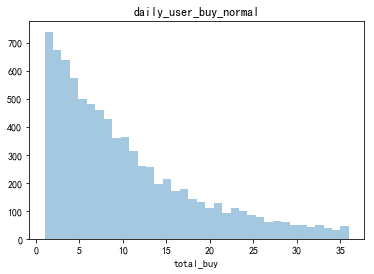

In [32]:
sns.distplot(data_user_buy[data_user_buy.total_buy < q_abnormal_U].reset_index()['total_buy'],kde=False)
plt.title('daily_user_buy_normal')

In [33]:
data_user_buy.total_buy.describe()

count    8886.000000
mean       13.527459
std        19.698786
min         1.000000
25%         4.000000
50%         8.000000
75%        17.000000
max       809.000000
Name: total_buy, dtype: float64

In [ ]:
"""
结合describe函数可得，淘宝用户消费次数大部分在17次以内

淘宝用户的数量整体上呈现递减的趋势
"""

In [34]:
# 2) 用户付费额度分析

In [35]:
#日人均消费次数

In [ ]:
"""
ARPPU（average revenue per paying user）是指从每位付费用户身上获得的收入，它反映的是每个付费用户的平均付费额度。
ARPPU=总收入/活跃付费用户数量
因为本数据集中没有消费金额，因此在计算过程中用消费次数代替消费金额
人均消费次数=消费总次数/消费人数

dail_ARRPU表示日人均消费次数 
"""

In [36]:
data_use_buy1=data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().reset_index().rename(columns={'behavior_type':'total'})
daily_ARRPU=data_use_buy1.groupby('date').apply(lambda x:x.total.sum()/x.total.count()).reset_index().rename(columns={0:'average'})

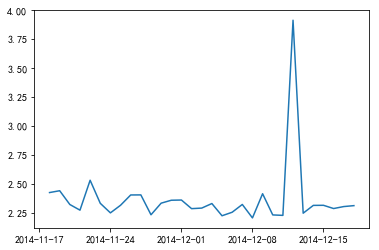

In [37]:
plt.plot(daily_ARRPU.date,daily_ARRPU.average)

In [ ]:
"""
整体来看，消费者平均消费次数在2.25到2.5之间波动

在双十二期间平均消费次数达到最高值，接近4
"""

In [38]:
#日平均每用户收入

In [ ]:
"""
ARPU(Average Revenue Per User)：平均每用户收入，
ARPU = 总收入/活跃用户数量

它可以衡量产品的盈利能力和发展活力。

活跃用户数平均消费次数=消费总次数/活跃用户人数(每天有操作行为的为活跃)

daily_ARPU表示活跃用户平均消费次数
"""

In [39]:
data_user['operation']=1
data_use_buy2=data_user.groupby(['date','user_id','behavior_type'])['operation'].count().reset_index().rename(columns={'operation':'total'})
daily_ARPU=data_use_buy2.groupby('date').apply(lambda x:x[x.behavior_type==4].total.sum()/len(x.user_id.unique())).reset_index().rename(columns={0:'average'})

Text(0.5,1,'daily_ARPU')

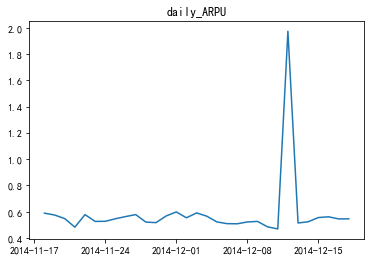

In [40]:
plt.plot(daily_ARPU.date,daily_ARPU.average)
plt.title('daily_ARPU')

In [ ]:
"""
整体来看，活跃用户平均消费次数在0.6左右波动

在双十二期间活跃用户平均消费次数达到最高值，接近2
"""

In [41]:
#付费率

In [ ]:
"""
付费率=消费人数/活跃用户人数

daily_afford_rate表示付费率
"""

In [42]:
daily_afford_rate=data_use_buy2.groupby('date').apply(lambda x:x[x.behavior_type==4].total.count()/len(x.user_id.unique())).reset_index().rename(columns={0:'average'})

Text(0.5,1,'daily_afford_rate')

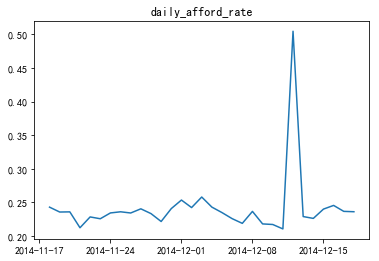

In [43]:
plt.plot(daily_afford_rate.date,daily_afford_rate.average)
plt.title('daily_afford_rate')

In [ ]:
"""
整体来看，每日活跃人群中，具有消费行为的在20%至25%之间

在双十二期间消费人数占比到最高值，在50%左右
"""

#### 2.1.4 复购和流失情况分析

In [44]:
#复购情况分析

In [ ]:
"""
复购情况，即两天以上有购买行为，一天多次购买算一次

复购率=有复购行为的用户数/有购买行为的用户总数

date_rebuy表示用户购买行为的发生的天数
rebuy_rate表示复购率
"""

In [45]:
date_rebuy=data_user[data_user.behavior_type==4].groupby('user_id')['date'].apply(lambda x:len(x.unique())).rename('rebuy_count')
rebuy_rate = round(date_rebuy[date_rebuy>=2].count()/date_rebuy.count(),4)
rebuy_rate

0.8717

In [ ]:
"""
淘宝用户复购率为0.8717
"""

In [46]:
#用户复购次数

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'rebuy_user')

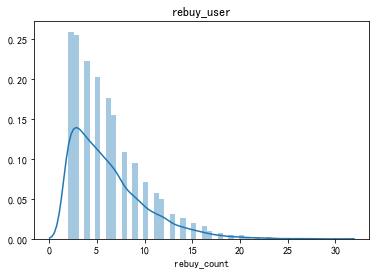

In [47]:
sns.distplot(date_rebuy[date_rebuy>=2])
plt.title("rebuy_user")

In [48]:
(date_rebuy[date_rebuy>=2]).describe()

count    7746.000000
mean        6.204622
std         3.883498
min         2.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        30.000000
Name: rebuy_count, dtype: float64

In [49]:
date_rebuy[date_rebuy>=2].mode()[0]

2

In [ ]:
"""
在复购的用户中，大部分人都会复购7次以下（75%），

并且复购1次（众数）的人数最多
"""

In [50]:
#复购时间间隔

In [ ]:
"""
data_day_buy指代用户在对应日期的消费次数

data_user_buy4指代复购用户用户在对应日期完成购买，是在间隔上一次购买多少天之后进行的。
"""

In [51]:
data_day_buy=data_user[data_user.behavior_type==4].groupby(['user_id','date'])['operation'].count().reset_index()
data_user_buy4=data_day_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna())
data_user_buy4=data_user_buy4.map(lambda x:x.days)

In [ ]:
#dataframe.diff(periods,axis)
#periods：表示移动的幅度。它是任意整数，
#如果是想让数据统一向下移动n个periods，则n为正，
#如果是想让数据向上移动n个periods，则n为负

Text(0,0.5,'gap_count')

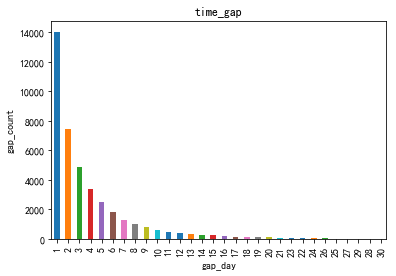

In [52]:
data_user_buy4.value_counts().plot(kind='bar')
plt.title('time_gap')
plt.xlabel('gap_day')
plt.ylabel('gap_count')

In [53]:
data_user_buy4.describe()

count    40315.000000
mean         3.732333
std          3.858599
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         30.000000
Name: date, dtype: float64

In [ ]:
"""
用户的复购时间间隔整体呈现递减趋势

用户的复购时间间隔大概在5天以内(75%的用户)，

5天之后很少出现复购的情况
"""

In [54]:
#流失分析（漏斗法）

In [ ]:
"""
流失分析思路

因为加入购物车量大于收藏量，因此置于前边

总浏览量 -> 点击量 -> 加入购物车量 -> 收藏量 -> 购买量

data_user_count表示4种行为的次数
pv_all表示总浏览量
"""

In [55]:
data_user_count=data_user.groupby('behavior_type')['user_id'].count().reset_index()
total_click = data_user_count.iloc[0,1]
total_cart = data_user_count.iloc[2,1]
total_collect = data_user_count.iloc[1,1]
total_buy = data_user_count.iloc[3,1]
pv_all=data_user['user_id'].count()
pv_all,total_click,total_cart,total_collect,total_buy

(12256906, 11550581, 343564, 242556, 120205)

In [ ]:
"""
总浏览量 12256906 -> 
点击量 11550581 -> 
加入购物车量 343564 -> 
收藏量 242556 -> 
购买量 120205

"""

In [56]:
a = (pv_all-total_click)/pv_all
b = (total_click-total_cart)/total_click
c = (total_cart-total_collect)/total_cart
d = (total_collect-total_buy)/total_collect

In [57]:
print("总浏览量—点击量 流失率：%.4f \n" % a + 
      "点击量-加入购物车量 流失率：%.4f \n" % b + 
      "加入购物车量-收藏量 流失率：%.4f \n" % c + 
      "收藏量-购买量 流失率：%.4f \n" % d)

总浏览量—点击量 流失率：0.0576 
点击量-加入购物车量 流失率：0.9703 
加入购物车量-收藏量 流失率：0.2940 
收藏量-购买量 流失率：0.5044 



### 2.2 用户价值分析（RFM模型）

In [ ]:
"""
原始RFM中，R = recency最近访问日期, 
F = frequency 访问频率， 
M = monetary 平均消费金额。
在这里由于数据中没有消费金额，所以M以购买频率来代替。

R 最近访问日期
最近访问日期，假设2014年12月18日为今天。
分三类。R<=7， R<=14, R>14, 分别为1,2,3
F 访问频率
访问频率计算 = count(pv)。
按频率分三类，最高到最低，分别为1,2,3
M 消费次数
消费次数计算 = count(buy).
按频率分为三类，最高到最低，分别为1,2,3.

rfm表示进行RFM模型所需要用到的三列数据
"""

In [58]:
rfm = data_user[['user_id','behavior_type','date']]

In [59]:
rfm.head()

,user_id,behavior_type,date
0,98047837,1,2014-12-06
1,97726136,1,2014-12-09
2,98607707,1,2014-12-18
3,98662432,1,2014-12-06
4,98145908,1,2014-12-16


#### 2.2.1 Recency 最近访问日期 

In [60]:
#计算最近访问日期recency
rfm['recency'] = max(rfm['date']) - rfm['date']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
#datetime格式改为string
rfm['recency'] = rfm['recency'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
#抽取时间间隔中的数字
rfm['recency_d'] = rfm['recency'].str.extract('(^\d+)')
#^:行开头，\d：数字，+：出现至少1次
rfm.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,behavior_type,date,recency,recency_d
0,98047837,1,2014-12-06,12 days 00:00:00.000000000,12
1,97726136,1,2014-12-09,9 days 00:00:00.000000000,9
2,98607707,1,2014-12-18,0 days 00:00:00.000000000,0
3,98662432,1,2014-12-06,12 days 00:00:00.000000000,12
4,98145908,1,2014-12-16,2 days 00:00:00.000000000,2


In [63]:
#按user_id 找到recency
recency=rfm.groupby('user_id')['recency_d'].min().reset_index()

In [64]:
#R转换为数字方便计算
recency['recency_d'] = recency['recency_d'].astype(int)
recency.head()

,user_id,recency_d
0,4913,0
1,6118,0
2,7528,11
3,7591,0
4,12645,0


In [65]:
#把Recency分类，分3组。用np.select
#np.select 三个参数：conditions, choices, default.
conditions = [
    recency['recency_d']<= 7,
    (recency['recency_d'] > 7)&(recency['recency_d'] <= 14),
    recency['recency_d']>14]


choices = ['1','2','3']
recency['r_class'] = np.select(conditions, choices)
recency.head()

,user_id,recency_d,r_class
0,4913,0,1
1,6118,0,1
2,7528,11,2
3,7591,0,1
4,12645,0,1


#### 2.2.2 Frequency 访问频率和 Monetary 消费次数 

In [66]:
#找到不同user_id的不同行为的访问次数
rfm_bType = rfm.groupby(['user_id','behavior_type'])['date'].count().reset_index()

In [67]:
rfm_bType.head()

,user_id,behavior_type,date
0,4913,1,1658
1,4913,2,49
2,4913,3,29
3,4913,4,6
4,6118,1,112


In [68]:
rfm_bType_pivot = rfm_bType.pivot(index = 'user_id',columns = 'behavior_type',values = 'date')
rfm_bType_pivot = rfm_bType_pivot.fillna(0)
rfm_bType_pivot.head()  

behavior_type,1,2,3,4
user_id,,,,
4913,1658.0,49.0,29.0,6.0
6118,112.0,4.0,0.0,1.0
7528,183.0,1.0,24.0,6.0
7591,824.0,0.0,14.0,21.0
12645,248.0,2.0,10.0,8.0


In [69]:
rfm_bType_pivot.head()

behavior_type,1,2,3,4
user_id,,,,
4913,1658.0,49.0,29.0,6.0
6118,112.0,4.0,0.0,1.0
7528,183.0,1.0,24.0,6.0
7591,824.0,0.0,14.0,21.0
12645,248.0,2.0,10.0,8.0


In [70]:
#点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）
#F(pv count)和 M(buy count)分类。按percentile

In [71]:
#计算F的33和66分位
pv_33 = np.percentile(rfm_bType_pivot[1],33)
pv_66 = np.percentile(rfm_bType_pivot[1],66)
pv_33,pv_66

(403.0, 1102.3400000000001)

In [72]:
#把Frequency分类, 分3组。用np.select
conditions = [
    rfm_bType_pivot[1] <= pv_33,
    (rfm_bType_pivot[1] > pv_33)&(rfm_bType_pivot[1] <= pv_66),
    rfm_bType_pivot[1] > pv_66]


choices = ['3','2','1']
rfm_bType_pivot['f_class'] = np.select(conditions, choices)

In [73]:
#计算M的33和66分位
buy_33 = np.percentile(rfm_bType_pivot[4],33)
buy_66 = np.percentile(rfm_bType_pivot[4],66)
buy_33,buy_66

(4.0, 11.0)

In [74]:
#把Monetary分类, 分3组。用np.select
conditions = [
    rfm_bType_pivot[4] <= buy_33,
    (rfm_bType_pivot[4] > buy_33)&(rfm_bType_pivot[4] <= buy_66),
    rfm_bType_pivot[4] > buy_66]


choices = ['3','2','1']
rfm_bType_pivot['m_class'] = np.select(conditions, choices)

In [75]:
rfm_bType_pivot.head()

behavior_type,1,2,3,4,f_class,m_class
user_id,,,,,,
4913,1658.0,49.0,29.0,6.0,1,2
6118,112.0,4.0,0.0,1.0,3,3
7528,183.0,1.0,24.0,6.0,3,2
7591,824.0,0.0,14.0,21.0,2,1
12645,248.0,2.0,10.0,8.0,3,2


In [76]:
#RFM全部分类完毕。把两张表join到一起
rfm_bType_pivot = rfm_bType_pivot.reset_index()
RFM_CLASS = pd.merge(recency,rfm_bType_pivot, on = 'user_id',how = 'outer')

In [77]:
RFM_CLASS.head()

,user_id,recency_d,r_class,1,2,3,4,f_class,m_class
0,4913,0,1,1658.0,49.0,29.0,6.0,1,2
1,6118,0,1,112.0,4.0,0.0,1.0,3,3
2,7528,11,2,183.0,1.0,24.0,6.0,3,2
3,7591,0,1,824.0,0.0,14.0,21.0,2,1
4,12645,0,1,248.0,2.0,10.0,8.0,3,2


In [78]:
#删掉不需要的列
del RFM_CLASS[1]
del RFM_CLASS[2]
del RFM_CLASS[3]
del RFM_CLASS[4]

In [79]:
RFM_CLASS.head()

,user_id,recency_d,r_class,f_class,m_class
0,4913,0,1,1,2
1,6118,0,1,3,3
2,7528,11,2,3,2
3,7591,0,1,2,1
4,12645,0,1,3,2


In [ ]:
"""
编号; 类别; 说明; 分组
1; 重要价值客户; RFM都很大，优质客户，需要保持; 111, 121, 211

2; 重要唤回客户; FM大，但最近无交易（R小），需要唤回; 311, 312, 212

3; 重要深耕客户; M大F小，最近有交易（R大），需要重点识别; 131, 122, 132, 221, 222, 231, 232

4; 重要挽留客户; M大，FR小。需要挽留; 331, 321

5; 潜力客户; RF大，交易金额小。需要挖掘; 112, 113, 223, 213

6; 新客户; 最近有交易，接触的新客户。; 123, 133

7; 一般维持客户; F大，RM小。一般维持。; 313, 322, 323

8; 流失客户; RFM都小。相当于流失。; 333, 233, 332
"""

In [80]:
#按照RFM定义把用户分为8类


RFM_CLASS['code'] = RFM_CLASS['r_class']+RFM_CLASS['f_class']+RFM_CLASS['m_class']
conditions = [
    (RFM_CLASS['code'] == '111')|(RFM_CLASS['code'] == '121')|(RFM_CLASS['code'] == '211'),
    (RFM_CLASS['code'] == '311')|(RFM_CLASS['code'] == '312')|(RFM_CLASS['code'] == '212'),
    (RFM_CLASS['code'] == '131')|(RFM_CLASS['code'] == '122')|(RFM_CLASS['code'] == '132')|
    (RFM_CLASS['code'] == '221')|(RFM_CLASS['code'] == '222')|(RFM_CLASS['code'] == '231')|
    (RFM_CLASS['code'] == '232'),
    (RFM_CLASS['code'] == '331')|(RFM_CLASS['code'] == '321'),
    (RFM_CLASS['code'] == '112')|(RFM_CLASS['code'] == '113')|(RFM_CLASS['code'] == '223')|
    (RFM_CLASS['code'] == '213'),
    (RFM_CLASS['code'] == '123')|(RFM_CLASS['code'] == '133'),
    (RFM_CLASS['code'] == '313')|(RFM_CLASS['code'] == '322')|(RFM_CLASS['code'] == '323'),
    (RFM_CLASS['code'] == '333')|(RFM_CLASS['code'] == '233')|(RFM_CLASS['code'] == '332')
]


choices = ['1','2','3','4','5','6','7','8']
RFM_CLASS['class_value'] = np.select(conditions, choices)
RFM_CLASS.head()

,user_id,recency_d,r_class,f_class,m_class,code,class_value
0,4913,0,1,1,2,112,5
1,6118,0,1,3,3,133,6
2,7528,11,2,3,2,232,3
3,7591,0,1,2,1,121,1
4,12645,0,1,3,2,132,3


In [81]:
#看每个组有多少个用户
class_value = RFM_CLASS.groupby(['class_value'])['user_id'].count().reset_index()
class_value

,class_value,user_id
0,1,3063
1,2,52
2,3,2300
3,4,10
4,5,1408
5,6,2060
6,7,25
7,8,1082


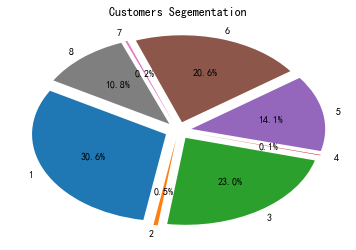

In [82]:
#用户分层可视化
labels = class_value.class_value
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
plt.pie(class_value.user_id,explode=explode,labels=labels,autopct='%1.1f%%',shadow=False,startangle=150)
plt.title("Customers Segementation")
plt.show()

In [ ]:
"""
占比前三的用户分类分别为：
“重要价值客户”（30.6%），
“重要深耕客户”（23%），和
“新客户”（20.6%）。
“流失客户”为1082人。占比10.8%。
"""

# 3. 总结与建议

In [ ]:
"""
结合AARRR模型，对应用户生命周期中的五个环节对用户行为进行分析

1.Acquisition - 用户获取
通过访问量分析可得，18点至20点是用户频繁访问的时间段，也是获取更多客户的潜在黄金时间，
可以在此时间段自行或与KOL、社交或视频平台等进行合作推广活动，并进行淘宝卖家的推送。

2.Activation - 用户激活
通过对于用户行为的漏斗模型流失分析可得
点击量-加入购物车量的流失率为0.9703  
从点击到加入购物车之间有较大的流失的，可能用户通过点击并没有能够挑选到满意的商品，导致了流失
可以通过问卷调查，或深入分析用户的购买行为，进一步发现用户可能感兴趣的商品，做到精准推送

3. Retention - 留存
淘宝用户复购率为0.8717，且用户的复购时间间隔大概在5天以内。整体情况较为良好但仍有改良空间。
为更进一步提高用户对于产品的依赖性，可以通过签到小游戏、签到领积分等活动增加用户登录频率和浏览时长
可以推广直播卖货和用户的互动，增加亲密指数

4. Revenue - 收入
整体来看，消费者平均消费次数在2.25到2.5之间波动，每日活跃人群中，具有消费行为的在20%至25%之间
可以通过分析找出高价值用户，并进行定制化产品推荐，对于一般用户，也可通过优惠券或折扣等方式促进购买。

5. Referral - 传播
淘宝可采用一些增长策略，如裂变营销等活动来促进传播，
也可以通过拼团、分享有好礼等方式鼓励用户进行分享
"""